# Мэтчинг продуктов

Цель проекта: разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

Оценка качества алгоритма планируется по метрике accuracy@5

Итоговую модель необходимо встроить в REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


Данные

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.


## Импорты

In [1]:
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler, power_transform

In [2]:
from sklearn.model_selection import ShuffleSplit

In [3]:
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection, \
DropHighPSIFeatures
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.preprocessing import PolynomialFeatures


In [5]:
from sklearn.model_selection import RandomizedSearchCV

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [7]:
import optuna

/home/amik/miniconda3/envs/tmpc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer

In [9]:
from joblib import Parallel, delayed

In [10]:
import warnings
warnings.filterwarnings('ignore', '.*')

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import pickle

In [13]:
import mkl

In [14]:
np.random.seed(42)

In [15]:
k = 5
n_cells = 333

## Вспомогательные функции

In [16]:
# Оценка accuracy@5
def test_preds(y, idx):
    acc = 0
    for target, el in zip(y.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    return 100 * acc / len(idx)

In [17]:
# функция генерации датафреймов для кандадатов к данной записи
def make_df(target, el, train_id):
    dfo = pd.DataFrame()
    for r in el:  # iterate ove candidates
        dftmp = pd.DataFrame(df_base2[[r]], index=[train_id])
        dftmp['tgt'] = int(target==base_index[r])
        dfo = pd.concat((dfo, dftmp), axis=0)
    return dfo

## Загрузка данных

### Словарь для корректной загрузки типов данных

In [18]:
# По умолчанию загружается float64, мы используем float32
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

### Базовый датасет

In [19]:
df_base = pd.read_csv("./content/base.csv", index_col=0, dtype=dict_base)

df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


In [20]:
df_base.shape

(2918139, 72)

In [21]:
# контроль корректности типов данных
df_base[['0','1','2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
dtypes: float32(3)
memory usage: 55.7+ MB


In [22]:
df_base.duplicated().sum()

0

In [23]:
df_base.isna().sum().sum()

0

Базовый датасет содержит 2,918,139 уникальных векторов длиной 72 признака, пропусков не наблюдается

In [24]:
# изготавливаем индекс товаров
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

### Обучающая выборка

In [25]:
df_train = pd.read_csv("./content/train.csv", index_col=0, dtype=dict_train)

df_train.shape

(100000, 73)

In [26]:
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base


In [27]:
df_train.isna().sum().sum()

0

In [28]:
df_train.duplicated().sum()

0

Обучающая выборка содержит 100,000 записей, пропусков нет, дубликатов нет

In [29]:
# Отделяем целевой признак
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

### Тестовая выборка

In [30]:
df_test = pd.read_csv("./content/validation.csv", index_col=0, dtype=dict_train)

df_test.shape

(100000, 72)

In [31]:
test_targets = pd.read_csv("./content/validation_answer.csv", index_col=0)

In [32]:
df_test.isna().sum().sum()

0

In [33]:
df_test.duplicated().sum()

0

Тестовая выборка содержит 100,000 записей, пропусков нет, дубликатв нет

### Разбиение на обучающую и валидационную выборки

In [34]:
splitter = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_ids, val_ids = splitter.split(df_train).__next__()

X_train = df_train.iloc[train_ids,:]
X_val = df_train.iloc[val_ids,:]
y_train = targets.iloc[train_ids]
y_val = targets.iloc[val_ids]

## EDA и предобработка данных

In [35]:
# для экономии ресурсов исследование данных будем проводить на случайной подвыборке
df_samples = X_train.sample(5000, random_state=42)

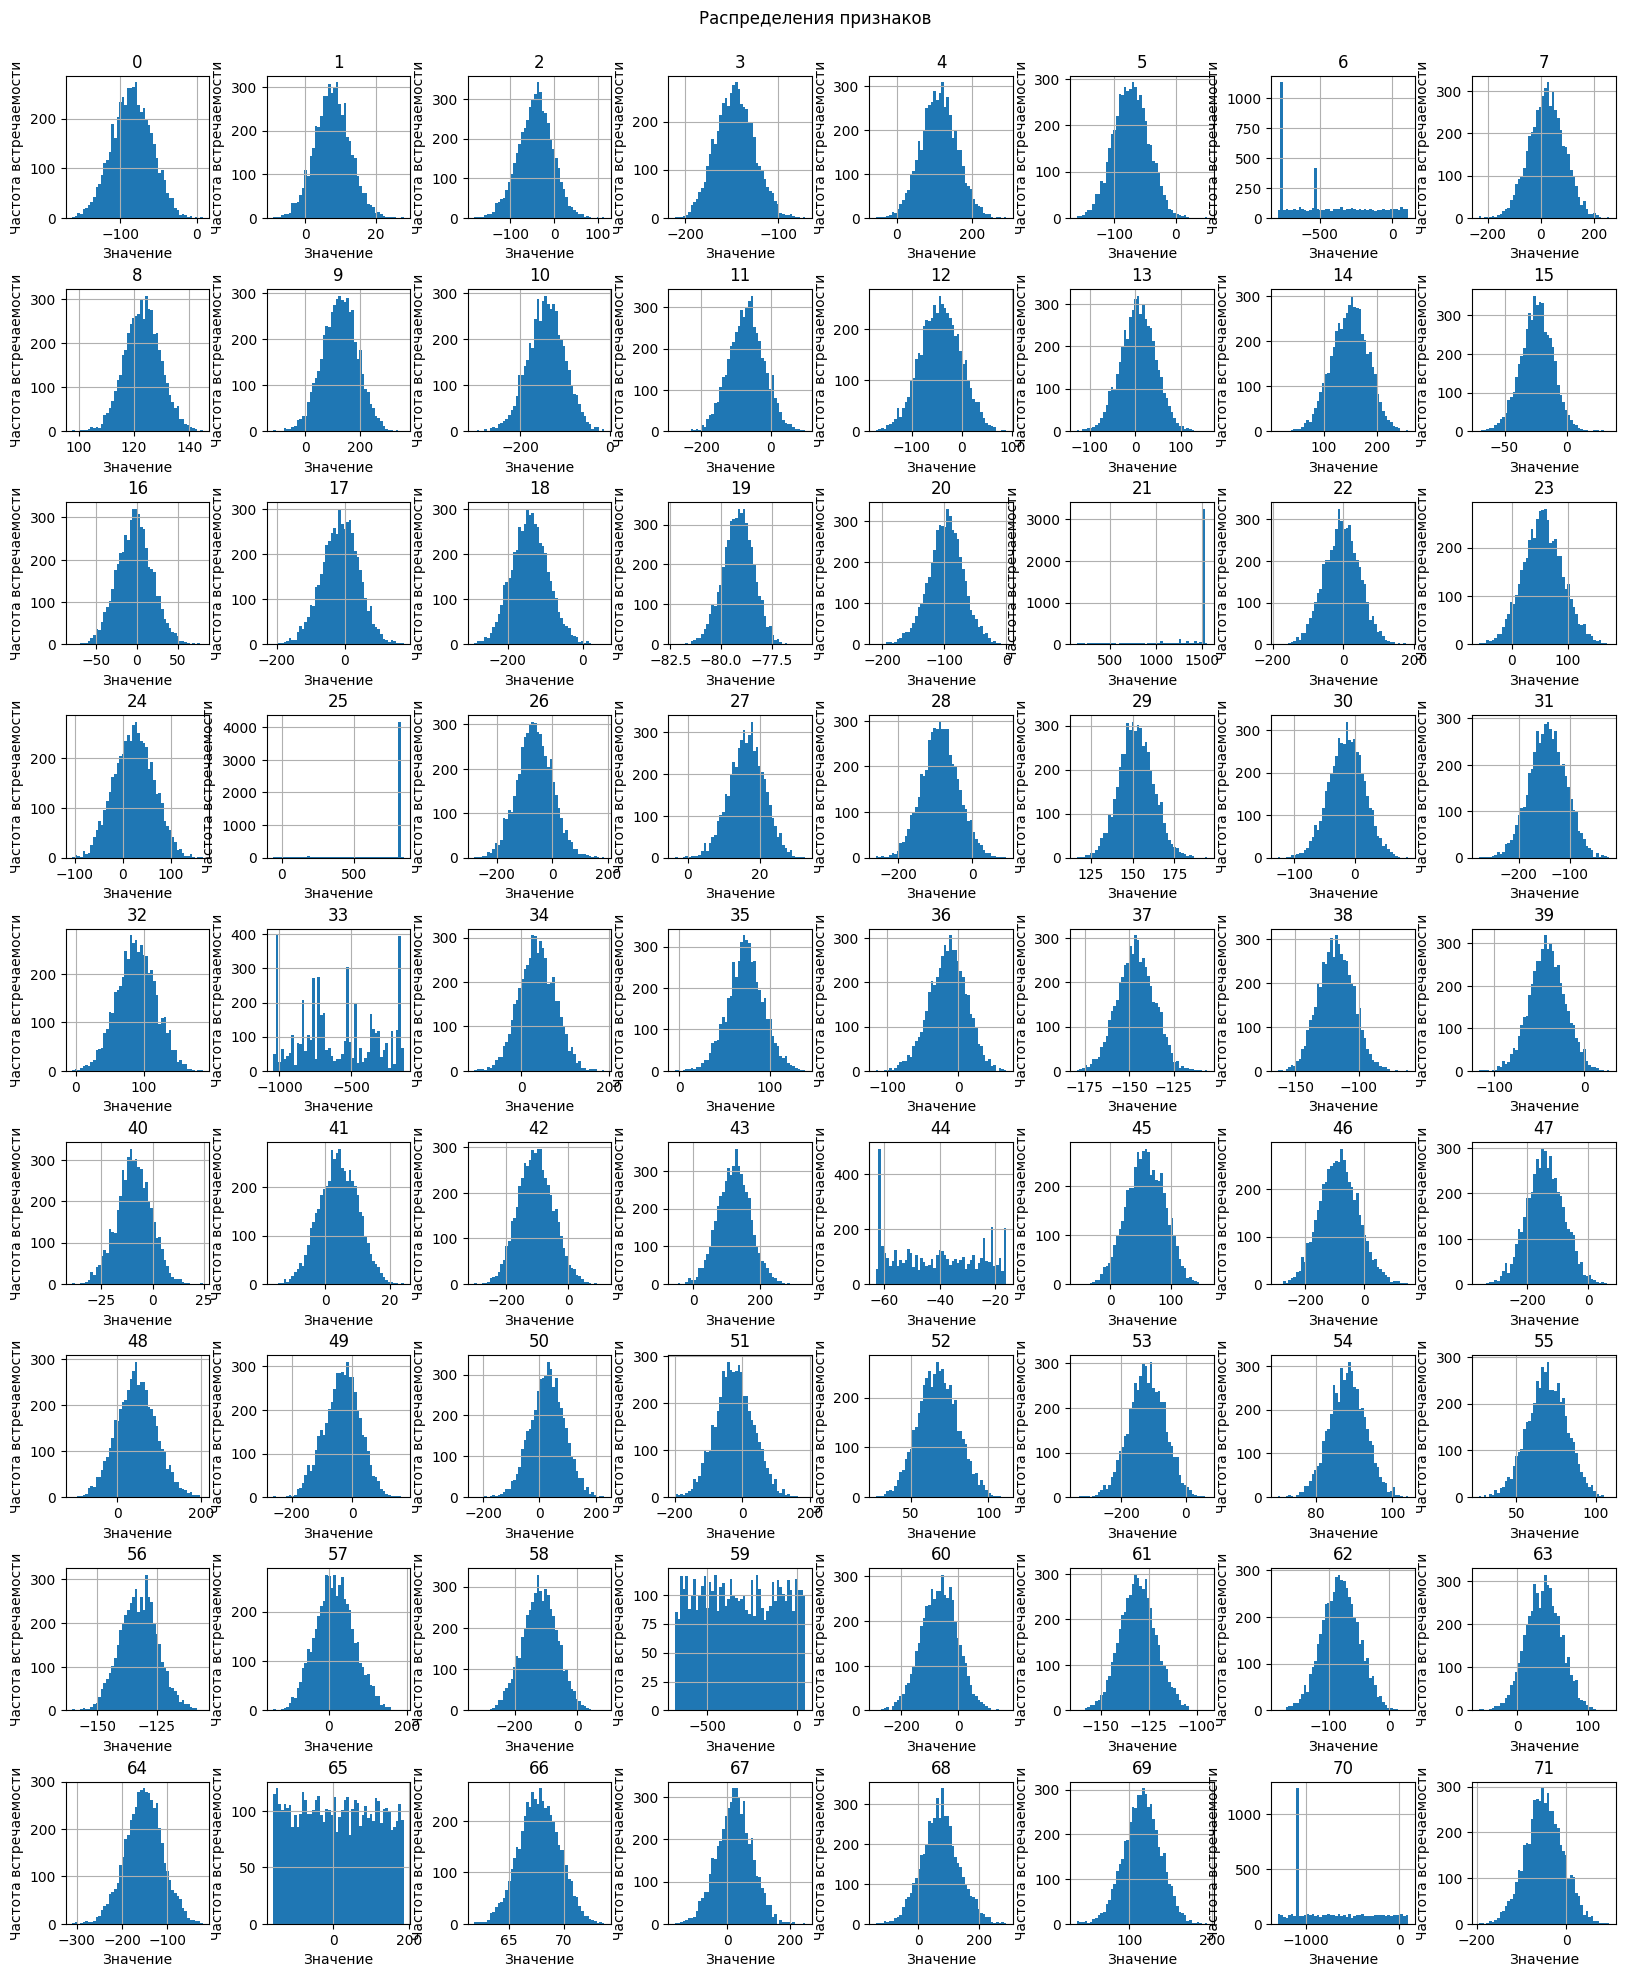

In [36]:
graphs = df_samples.hist(figsize=[20, 22], bins=50);
for gr in graphs.ravel():
    gr.set_ylabel("Частота встречаемости")
    gr.set_xlabel("Значение")
plt.suptitle('Распределения признаков', y=0.98);
plt.subplots_adjust(top=0.95,
                    wspace=0.4,
                    hspace=0.5);

Видно, что часть признаков ведет себя аномально:
- признак 6: две области доминирующих значений в начале и середине диапазона
- признак 21, 25: доминирующее значение в правой части диапазона
- признак 44: некоторое доминирование значений в начале диапазона
- признак 70: доминирующие значения в начале диапазона

### Оценка возможности фильтрации аномальных значений

In [37]:
df_samples[["6", "21", "25", "44", "70"]].describe(
    percentiles=(0.002, 0.01,0.05,0.07, 0.1, 0.2, 0.5,0.7,0.95,0.99, 0.998))

,6,21,25,44,70
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-442.539337,1291.934448,738.720581,-40.735275,-709.815735
std,279.184875,378.592804,196.926331,14.728107,407.056396
min,-791.443909,136.900452,-61.488625,-63.088921,-1297.622925
0.2%,-787.951238,150.974920,-43.082907,-62.999516,-1294.412293
1%,-778.525629,190.510222,-4.391877,-62.236128,-1281.419553
5%,-759.626038,376.677879,175.595703,-61.441418,-1208.091174
7%,-759.626038,466.075980,267.560757,-61.441418,-1165.650084
10%,-759.626038,599.625183,445.024252,-61.441418,-1117.104504
20%,-759.626038,1050.807275,813.770081,-56.679410,-1074.464844


Видно, что на долю частых значений приходится порядка 80% данных, то есть фильтрация приведет к большой потере данных и потому не целесообразна

### Оценка возможности нормализации аномальных признаков

Попробуем преобразоване Yeo-Johnson для того, чтобы сделать распределение более гауссовым

In [38]:
norm_df = df_samples[["6", "21", "25", "44", "70"]].copy()

In [39]:
norm_df.loc[:,:] = power_transform(norm_df.values, 
                method='yeo-johnson')

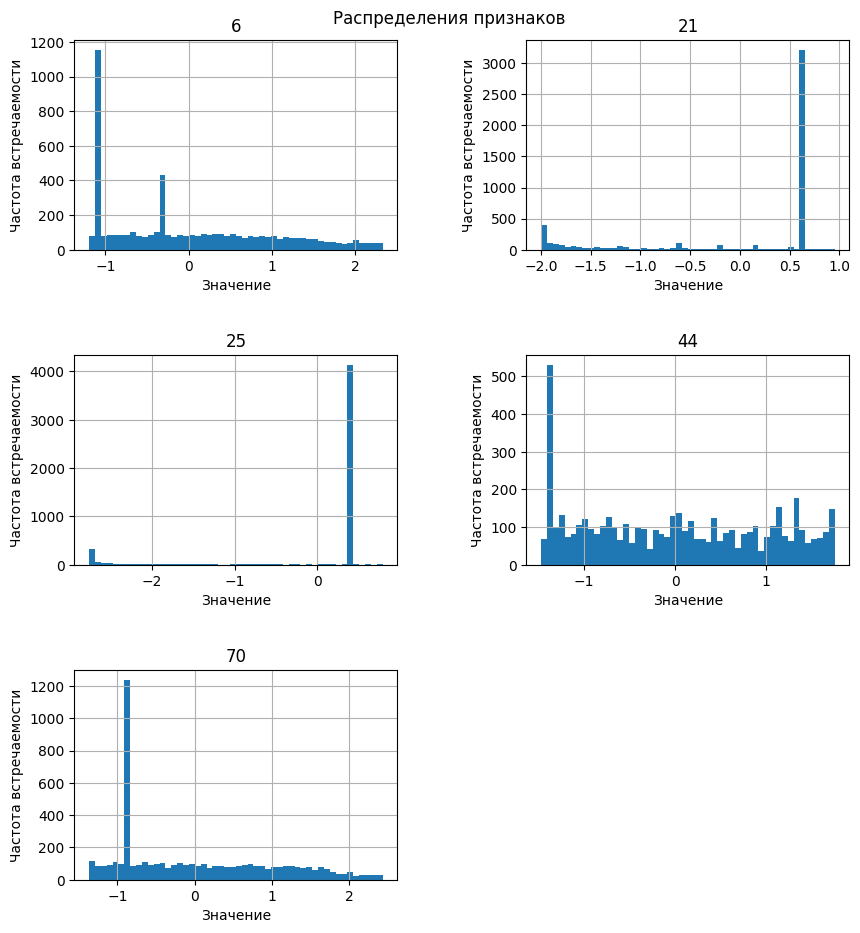

In [40]:
graphs = norm_df.hist(bins=50, figsize=(10,10))
for gr in graphs.ravel():
    gr.set_ylabel("Частота встречаемости")
    gr.set_xlabel("Значение")
plt.suptitle('Распределения признаков', y=0.98);
plt.subplots_adjust(top=0.95,
                    wspace=0.4,
                    hspace=0.5);

In [41]:
norm_df.describe(
    percentiles=(0.002, 0.01,0.05,0.07, 0.1, 0.2, 0.5,0.7,0.95,0.99, 0.998))

,6,21,25,44,70
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,-2.727509e-08,-9.155274e-09,2.841949e-08,1.258850e-08,4.577637e-09
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-1.196666e+00,-1.997516e+00,-2.756227e+00,-1.469234e+00,-1.365510e+00
0.2%,-1.185352e+00,-1.997237e+00,-2.756227e+00,-1.463735e+00,-1.358509e+00
1%,-1.154801e+00,-1.996042e+00,-2.756227e+00,-1.416722e+00,-1.330162e+00
5%,-1.093460e+00,-1.975691e+00,-2.732055e+00,-1.367656e+00,-1.169611e+00
7%,-1.093460e+00,-1.951423e+00,-2.664179e+00,-1.367656e+00,-1.076234e+00
10%,-1.093460e+00,-1.887039e+00,-2.292012e+00,-1.367656e+00,-9.689982e-01
20%,-1.093460e+00,-1.233782e+00,4.158763e-01,-1.070924e+00,-8.744150e-01


Принципиальных изменений не видно.

### Поиск признаков с низкой вариабельностью

In [42]:
# определим порог вариабельности как 50% одинаковых значений
dcf = DropConstantFeatures(tol=0.5)

In [43]:
dcf.fit(df_samples)

DropConstantFeatures(tol=0.5)

In [44]:
# Какие признаки будут удалены?
dcf.features_to_drop_

['21', '25']

In [45]:
df_samples = dcf.transform(df_samples)

Признаки 21 и 25 можно отбросить как обладающие низкой вариабельностью

### Поиск признаков с высокой корреляцией

In [46]:
scs = SmartCorrelatedSelection(threshold=0.7)

In [47]:
scs.fit(df_samples)

SmartCorrelatedSelection(threshold=0.7)

In [48]:
scs.features_to_drop_

[]

Признаков с высокой корреляцией не выявлено

### Поиск признаков с высокой нестабильностью

In [49]:
psi = DropHighPSIFeatures()

In [50]:
psi.fit(df_samples)

DropHighPSIFeatures()

In [51]:
psi.features_to_drop_

[]

Признаков с высокой нестабильностью не обнаружено

### Обработка признаков с сильно ненормальным распределением

Представляется полезным обработать признаки 6, 44 и 70 

In [52]:
efd = EqualFrequencyDiscretiser(variables=['6','44','70'])

In [53]:
efd.fit(df_samples)

EqualFrequencyDiscretiser(variables=['6', '44', '70'])

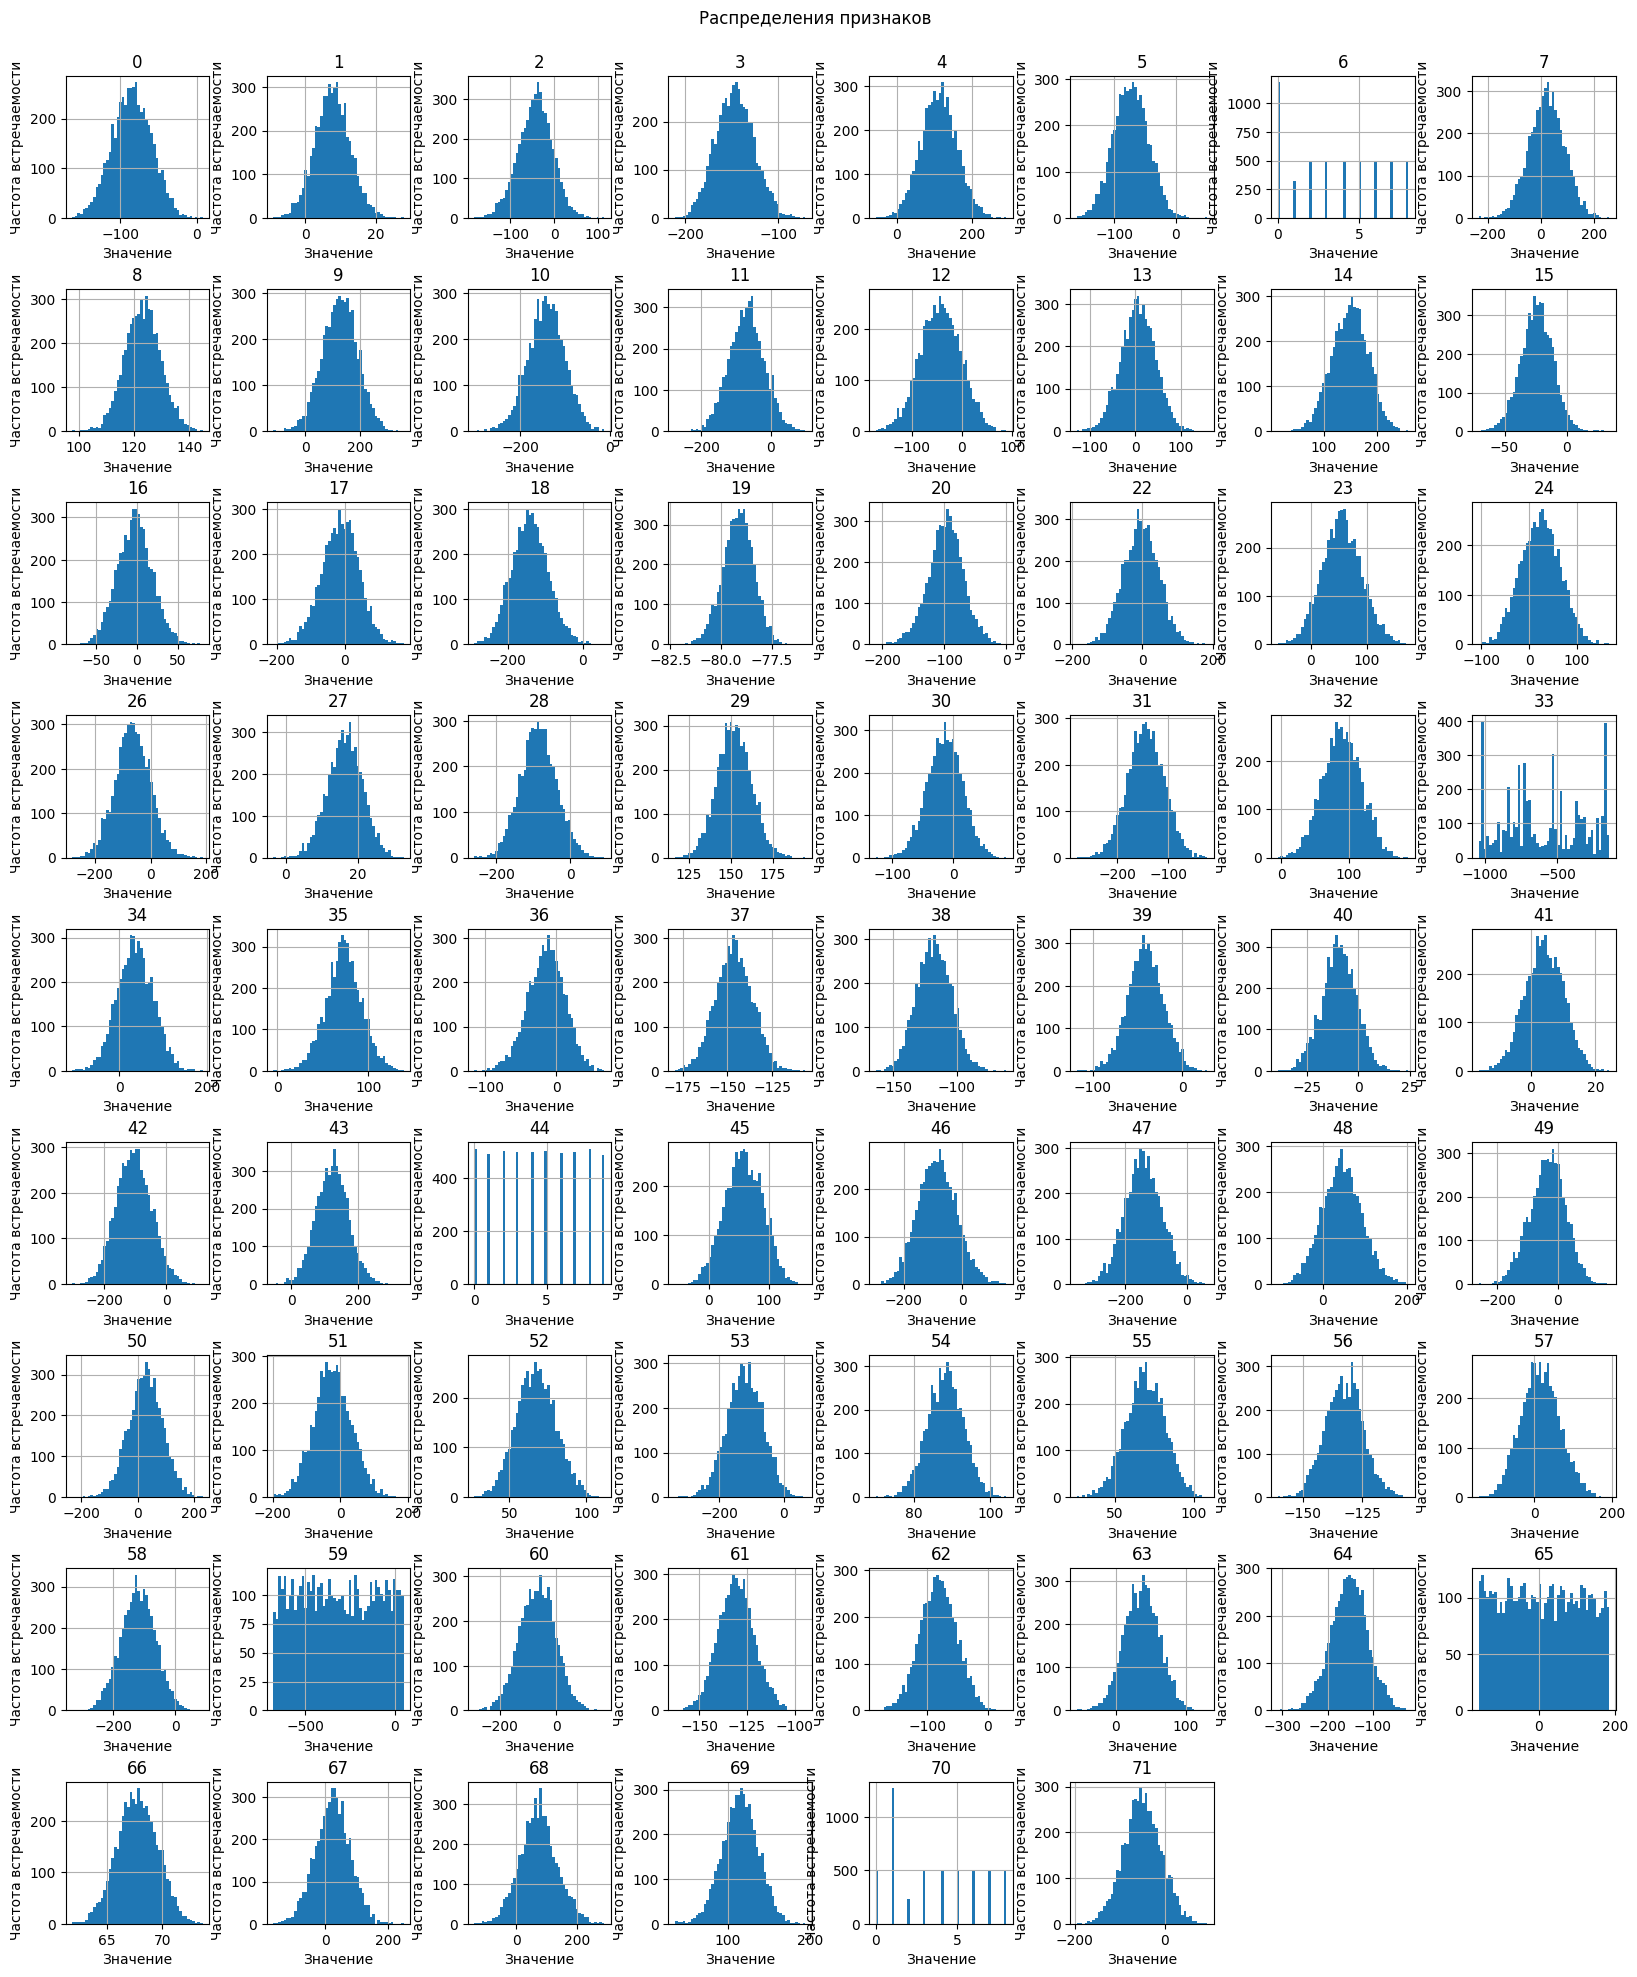

In [54]:
graphs = efd.transform(df_samples).hist(figsize=[20, 22], bins=50);
for gr in graphs.ravel():
    gr.set_ylabel("Частота встречаемости")
    gr.set_xlabel("Значение")
plt.suptitle('Распределения признаков', y=0.98);
plt.subplots_adjust(top=0.95,
                    wspace=0.4,
                    hspace=0.5);

In [55]:
df_samples = efd.transform(df_samples)

Видно, что картина в целом стала лучше - разница в частотах для обработанных признаков снизилась до отличия в два раза

In [56]:
# Итоговый список признаков
final_vars = list(df_samples.columns)

### Генерация вторичных признаков

In [57]:
mf = PolynomialFeatures(include_bias=False, interaction_only=True)

In [58]:
mf.fit_transform(df_samples).shape

(5000, 2485)

Получается довольно много признаков, отложим до стадии классификаторов

### Масштабирование

Признаки довольно сильно отличаются друг от друга, потому применим масштабирование

In [59]:
scaler = RobustScaler()

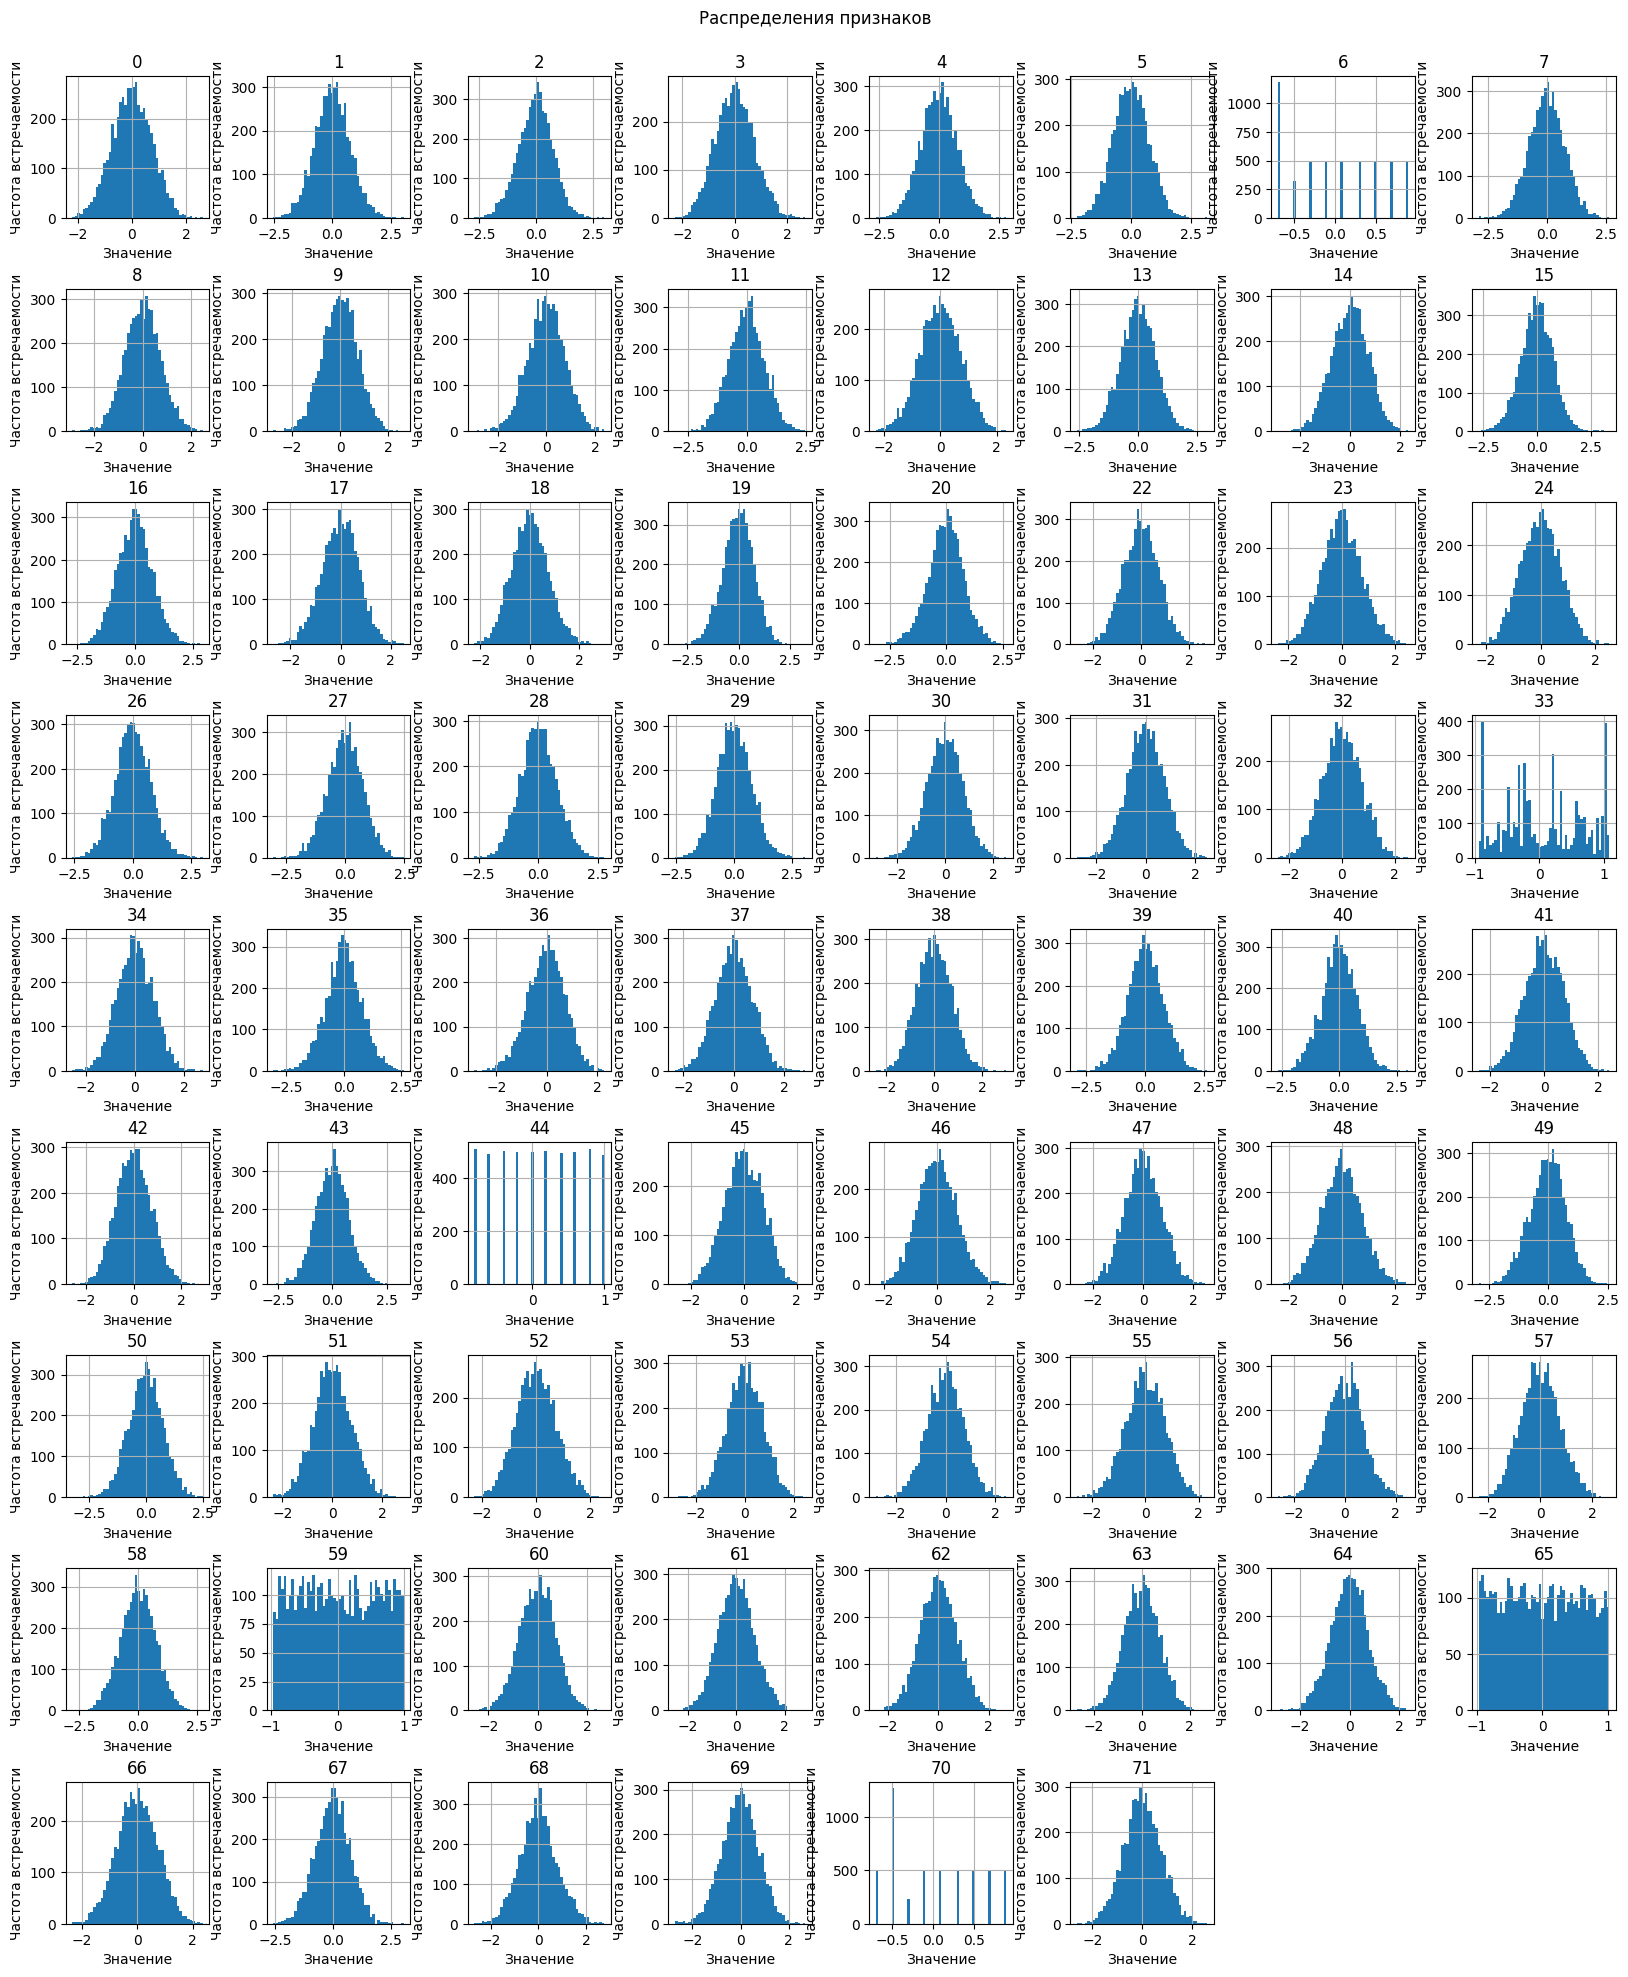

In [60]:
graphs = pd.DataFrame(scaler.fit_transform(df_samples), columns=df_samples.columns)\
            .hist(figsize=[20, 22], bins=50);
for gr in graphs.ravel():
    gr.set_ylabel("Частота встречаемости")
    gr.set_xlabel("Значение")
plt.suptitle('Распределения признаков', y=0.98);
plt.subplots_adjust(top=0.95,
                    wspace=0.4,
                    hspace=0.5);

Видно, что теперь значения всех признаков находятся в близком диапазоне

### Пайплайн - первая часть

In [61]:
pipe = Pipeline([
    ('drop_constant', DropConstantFeatures(tol=0.5)),
    ('decorrelate', SmartCorrelatedSelection(threshold=0.7)),
    ('drop_unstable', DropHighPSIFeatures()),
    ('discretize', EqualFrequencyDiscretiser(variables=['6','44','70'])),
    ('scale', RobustScaler())
])

In [62]:
pipe.fit(X_train)

Pipeline(steps=[('drop_constant', DropConstantFeatures(tol=0.5)),
                ('decorrelate', SmartCorrelatedSelection(threshold=0.7)),
                ('drop_unstable', DropHighPSIFeatures()),
                ('discretize',
                 EqualFrequencyDiscretiser(variables=['6', '44', '70'])),
                ('scale', RobustScaler())])

In [63]:
df_base2 = pipe.transform(df_base)
X_train_p = pipe.transform(X_train)
X_val_p = pipe.transform(X_val)

## Базовая модель

Будем использовать IndexFlatL2 и IndexIVFFlat, так как их можно обрабатывать с помощью GPU и, следовательно, повысить скорость поиска

In [64]:
res = faiss.StandardGpuResources()

# return all gpu memory after use
res.noTempMemory()

In [65]:
dims = df_base.shape[1]
n_cells = 333
quantizer = faiss.GpuIndexFlatL2(res, dims)
idx_l2 = faiss.GpuIndexIVFFlat(res, quantizer, dims, n_cells)

In [66]:
idx_l2.train(np.ascontiguousarray(df_base).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [67]:
vecs, idx_train = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), k)

vecs, idx_val = idx_l2.search(np.ascontiguousarray(X_val.values).astype('float32'), k)

In [68]:
# free gpu memory
idx_l2.reset()

In [69]:
print(f"Accuracy@5 train {test_preds(y_train, idx_train):.2f}%")
print(f"Accuracy@5 validation {test_preds(y_val, idx_val):.2f}%")

Accuracy@5 train 5.62%
Accuracy@5 validation 5.52%


Довольно низкое качество, модель явно нуждается в оптимизации

## Оптимизация FAISS

### Использование предобработанных данных

In [70]:
dims = df_base2.shape[1]
n_cells = 333

In [71]:
quantizer2 = faiss.GpuIndexFlatL2(res, dims)
idx_l2 = faiss.GpuIndexIVFFlat(res, quantizer2, dims, n_cells)

In [72]:
idx_l2.train(np.ascontiguousarray(df_base2).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))

In [73]:
vecs, idx_train = idx_l2.search(np.ascontiguousarray(X_train_p).astype('float32'), k)
vecs, idx_val = idx_l2.search(np.ascontiguousarray(X_val_p).astype('float32'), k)

In [74]:
# free gpu memory
idx_l2.reset()

In [75]:
print(f"Accuracy@5 train {test_preds(y_train, idx_train):.2f}%")
print(f"Accuracy@5 validation {test_preds(y_val, idx_val):.2f}%")

Accuracy@5 train 59.86%
Accuracy@5 validation 59.75%


Точность поиска существенно возросла, хотя 59% - все же не слишком много

### Оптимизация гиперпараметров

In [76]:
dims = df_base2.shape[1]

In [77]:
idx_l2.reset()

## Оптимизация классификатров

### Построение обучающей выборки

In [78]:
# параметры FAISS
dims = df_base2.shape[1]
n_cells = 3416
nprobe = 192

In [79]:
# подготовка индекса FAISS
quantizer2 = faiss.GpuIndexFlatL2(res, dims)
idx_l2 = faiss.GpuIndexIVFFlat(res, quantizer2, dims, int(n_cells))
idx_l2.train(np.ascontiguousarray(df_base2).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
idx_l2.nprobe = int(nprobe)

In [80]:
vecs, idx_train = idx_l2.search(np.ascontiguousarray(X_train_p).astype('float32'), 5)
vecs, idx_val = idx_l2.search(np.ascontiguousarray(X_val_p).astype('float32'), 5)

Размер данных достаточно большой, потому для ускорения используем параллелизацию

In [81]:
outs = Parallel(n_jobs=12, verbose=1,
                backend='multiprocessing')(
    delayed(make_df)(target, el, train_id) 
        for target, el, train_id in 
            zip(y_train.values.tolist(), idx_train.tolist(), train_ids))

[Parallel(n_jobs=12)]: Using backend MultiprocessingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 3560 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 19560 tasks      | elapsed:    7.3s
[Parallel(n_jobs=12)]: Done 41960 tasks      | elapsed:   15.2s
[Parallel(n_jobs=12)]: Done 70760 tasks      | elapsed:   25.4s
[Parallel(n_jobs=12)]: Done 75000 out of 75000 | elapsed:   26.7s finished


In [82]:
#  датафрейм кандидатов
df_train_clf = pd.concat(outs, axis=0)
# датафрейм запросов
df_train_clf0 = pd.DataFrame(X_train_p, index=train_ids)
# объединенный датафрейм
df_train_clf = df_train_clf.join(df_train_clf0, lsuffix='c', rsuffix='q')

In [83]:
df_train_clf.head()

,0c,1c,2c,3c,4c,5c,6c,7c,8c,9c,...,60q,61q,62q,63q,64q,65q,66q,67q,68q,69q
0,0.700478,1.465176,-0.038138,-1.484934,1.014582,-0.168694,-0.7,0.316789,-1.188438,-0.541111,...,-0.600599,0.977519,-0.07962,-0.674194,-0.766983,0.145836,-0.123494,0.670052,0.5,0.407094
0,0.599186,1.427309,0.205205,-0.853013,1.350590,-0.099439,0.3,-0.101726,-1.676310,-0.943735,...,-0.600599,0.977519,-0.07962,-0.674194,-0.766983,0.145836,-0.123494,0.670052,0.5,0.407094
0,0.784269,1.721376,-0.557166,-1.260421,1.359026,-0.069430,-0.3,0.077745,-1.383215,-0.127645,...,-0.600599,0.977519,-0.07962,-0.674194,-0.766983,0.145836,-0.123494,0.670052,0.5,0.407094
0,0.530113,1.235126,-0.213295,-1.164582,0.514659,0.290278,-0.1,0.113083,-1.277193,-0.180851,...,-0.600599,0.977519,-0.07962,-0.674194,-0.766983,0.145836,-0.123494,0.670052,0.5,0.407094
0,0.199402,1.586662,-0.331714,-1.362662,1.108082,-0.162364,0.3,-0.060589,-0.959065,-0.198818,...,-0.600599,0.977519,-0.07962,-0.674194,-0.766983,0.145836,-0.123494,0.670052,0.5,0.407094


In [84]:
df_train_clf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375000 entries, 0 to 99998
Columns: 141 entries, 0c to 69q
dtypes: float64(140), int64(1)
memory usage: 406.3 MB


In [85]:
# разделение признаков и таргета
target_train = df_train_clf['tgt']
df_train_clf = df_train_clf.drop('tgt', axis=1)

In [86]:
outs = Parallel(n_jobs=12, verbose=1,
                backend='multiprocessing')(
    delayed(make_df)(target, el, train_id) 
        for target, el, train_id in 
            zip(y_val.values.tolist(), idx_val.tolist(), val_ids))

[Parallel(n_jobs=12)]: Using backend MultiprocessingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 3560 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 19560 tasks      | elapsed:    7.6s
[Parallel(n_jobs=12)]: Done 25000 out of 25000 | elapsed:   10.0s finished


In [87]:
df_val_clf = pd.concat(outs, axis=0)

df_val_clf0 = pd.DataFrame(X_val_p, index=val_ids)

df_val_clf = df_val_clf.join(df_val_clf0, lsuffix='c', rsuffix='q')

In [88]:
df_val_clf.head()

,0c,1c,2c,3c,4c,5c,6c,7c,8c,9c,...,60q,61q,62q,63q,64q,65q,66q,67q,68q,69q
8,-0.339988,-0.112584,-0.250806,0.229023,0.880605,-0.703663,-0.7,1.294542,-0.022070,-0.231498,...,0.15128,0.261647,0.268093,0.601781,0.338455,-0.57589,-0.224755,-0.774541,0.9,-0.220594
8,-0.400670,-0.442725,-0.212249,-0.041646,0.779861,-0.742539,-0.1,1.367067,-0.090341,-0.244125,...,0.15128,0.261647,0.268093,0.601781,0.338455,-0.57589,-0.224755,-0.774541,0.9,-0.220594
8,-0.255835,0.152952,-0.192533,0.260681,0.795744,-0.813096,-0.7,1.186028,-0.073513,-0.058432,...,0.15128,0.261647,0.268093,0.601781,0.338455,-0.57589,-0.224755,-0.774541,0.9,-0.220594
8,-0.363341,-0.839013,-0.925944,0.081105,0.748449,-0.342143,-0.1,1.434127,-0.407246,-0.445838,...,0.15128,0.261647,0.268093,0.601781,0.338455,-0.57589,-0.224755,-0.774541,0.9,-0.220594
8,-0.197485,-0.003976,-0.257704,0.182967,0.177322,-0.728645,-0.1,1.248278,-0.044190,0.502405,...,0.15128,0.261647,0.268093,0.601781,0.338455,-0.57589,-0.224755,-0.774541,0.9,-0.220594


In [89]:
df_val_clf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125000 entries, 8 to 99999
Columns: 141 entries, 0c to 69q
dtypes: float64(140), int64(1)
memory usage: 135.4 MB


In [90]:
# разделение признаков и таргета
target_val = df_val_clf['tgt']
df_val_clf = df_val_clf.drop('tgt', axis=1)

### Сравнение классификаторов

### Оптимизация гиперпараметров

In [91]:
def objective(trial):

    param = dict(
        hidden_layer_sizes=trial.suggest_int('hidden_layer_sizes', 10,200),
        activation=trial.suggest_categorical('activation',['identity', 'logistic', 'tanh', 'relu']),
        alpha=trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        batch_size=trial.suggest_int('batch_size', 10,200)
    )    

    clf = MLPClassifier(**param)
    
    clf.fit(df_train_clf, target_train)
    
    preds = clf.predict(df_val_clf)
    score = f1_score(target_val, preds)
    
    return score

## Итоговый пайплайн 

### Обучение моделей на полной выборке

#### Пайплайн подготовки данных

In [92]:
pipe.fit(df_train)

Pipeline(steps=[('drop_constant', DropConstantFeatures(tol=0.5)),
                ('decorrelate', SmartCorrelatedSelection(threshold=0.7)),
                ('drop_unstable', DropHighPSIFeatures()),
                ('discretize',
                 EqualFrequencyDiscretiser(variables=['6', '44', '70'])),
                ('scale', RobustScaler())])

In [93]:
with open('./models/pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

#### FAISS

In [94]:
df_base2 = pipe.transform(df_base)

In [95]:
# параметры FAISS
dims = df_base2.shape[1]
n_cells = 3416
nprobe = 192

In [96]:
res = faiss.StandardGpuResources()
# return all gpu memory after use
res.noTempMemory()

In [97]:
# подготовка индекса FAISS
quantizer2 = faiss.GpuIndexFlatL2(res, dims)
idx_l2 = faiss.GpuIndexIVFFlat(res, quantizer2, dims, int(n_cells))
idx_l2.train(np.ascontiguousarray(df_base2).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
idx_l2.nprobe = int(nprobe)

In [98]:
# переносим индекс на cpu для сохранения
idx_l2cpu = faiss.index_gpu_to_cpu(idx_l2)

In [99]:
faiss.write_index(idx_l2cpu, "./models/trained_block.index") 

#### Классификатор

##### Подготовка обучающей выборки

In [100]:
df_train2 = pipe.transform(df_train)

In [101]:
vecs, idx_train = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), 5)

In [102]:
outs = Parallel(n_jobs=12, verbose=1,
                backend='multiprocessing')(
    delayed(make_df)(target, el, train_id) 
        for target, el, train_id in 
            zip(targets.values.tolist(), idx_train.tolist(), range(df_train.shape[0])))

[Parallel(n_jobs=12)]: Using backend MultiprocessingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 3560 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 19560 tasks      | elapsed:    7.3s
[Parallel(n_jobs=12)]: Done 41960 tasks      | elapsed:   15.4s
[Parallel(n_jobs=12)]: Done 70760 tasks      | elapsed:   25.4s
[Parallel(n_jobs=12)]: Done 99660 tasks      | elapsed:   35.6s
[Parallel(n_jobs=12)]: Done 100000 out of 100000 | elapsed:   35.6s finished


In [103]:
#  датафрейм кандидатов
df_train_clf = pd.concat(outs, axis=0)

In [104]:
# датафрейм запросов
df_train_clf0 = pd.DataFrame(df_train2, index=range(df_train.shape[0]))
# объединенный датафрейм
df_train_clf = df_train_clf.join(df_train_clf0, lsuffix='c', rsuffix='q')

In [105]:
# разделение признаков и таргета
target_train = df_train_clf['tgt']
df_train_clf = df_train_clf.drop('tgt', axis=1)

##### Обучение и сохранение классификатора

In [106]:
param = {
    'hidden_layer_sizes': 57,
    'activation': 'relu',
    'alpha': 2.4329188723345664e-05,
    'batch_size': 64}
clf = MLPClassifier(**param)

In [107]:
# увеличиваем число потоков для ускорения обучения модели
mkl.set_num_threads(8)

8

In [108]:
clf2 = XGBClassifier()

In [109]:
with open('./models/clf.pkl', 'rb') as f:
    clf = pickle.load(f)

In [110]:
with open('./models/clf2.pkl', 'rb') as f:
    clf2 = pickle.load(f)

### Оценка тестовой выборки

In [111]:
df_test2 = pipe.transform(df_test)

In [112]:
vecs, idx_test = idx_l2.search(np.ascontiguousarray(df_test2).astype('float32'), 5)

In [113]:
outs = Parallel(n_jobs=12, verbose=1,
                backend='multiprocessing')(
    delayed(make_df)(target, el, train_id) 
        for target, el, train_id in 
            zip(test_targets.values.tolist(), idx_test.tolist(), range(df_test2.shape[0])))

[Parallel(n_jobs=12)]: Using backend MultiprocessingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 3560 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 19560 tasks      | elapsed:    7.6s
[Parallel(n_jobs=12)]: Done 41960 tasks      | elapsed:   15.7s
[Parallel(n_jobs=12)]: Done 70760 tasks      | elapsed:   26.1s
[Parallel(n_jobs=12)]: Done 99660 tasks      | elapsed:   35.7s
[Parallel(n_jobs=12)]: Done 100000 out of 100000 | elapsed:   35.8s finished


In [114]:
#  датафрейм кандидатов
df_test_clf = pd.concat(outs, axis=0)

In [115]:
# датафрейм запросов
df_test_clf0 = pd.DataFrame(df_test2, index=range(df_test2.shape[0]))
# объединенный датафрейм
df_test_clf = df_test_clf.join(df_test_clf0, lsuffix='c', rsuffix='q')

In [116]:
# разделение признаков и таргета
target_test = df_test_clf['tgt']
df_test_clf = df_test_clf.drop('tgt', axis=1)

In [117]:
# Основной классификатор
preds = clf.predict(df_test_clf)

print(f'Accuracy {accuracy_score(target_test, preds):.3f}')

Accuracy 0.883


In [118]:
# Дополнительный классификатор
preds = clf2.predict(df_test_clf)

print(f'Accuracy {accuracy_score(target_test, preds):.3f}')

Accuracy 0.901


In [119]:
with open('./models/base_index.pkl', 'wb') as f:
    pickle.dump(base_index, f)

## Заключение

Цель проекта: разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.

Оценка качества алгоритма планируется по метрике accuracy@5

Итоговую модель необходимо встроить в REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

**Описание данных**

Имеющиеся данные состоят из трех частей:
- описание товаров из 2,918,139 записей (все уникальные)
- обучающая выборка из 100,000 записей (все уникальные)
- тестовая выборка из 100,000 записей (все уникальные)

Данные описаны 72 признаками (вещественные числа), пропусков нет.

**Подготовка данных**

Обучающая выборка была разбита на собственно обучение и валидацию в соотношении 75:25.

Исследовательский анализ данных показал, что большая часть признаков имеет нормальное распеределение, часть - монотонное, и 5 признаков ведут себя аномально.
- признак 6: две области доминирующих значений в начале и середине диапазона
- признак 21, 25: доминирующее значение в правой части диапазона
- признак 44: некоторое доминирование значений в начале диапазона
- признак 70: доминирующие значения в начале диапазона

На долю частых значений приходится порядка 80% данных, то есть фильтрация приведет к большой потере данных и потому не целесообразна.

Попытка применения преобразованя Yeo-Johnson для того, чтобы сделать распределение более гауссовым, значимых результатов не дала.

Однако, по критерию низкой вариабельности (50% или более данных одинаковые) признаки 21 и 25 были отброшены как обладающие низкой вариабельностью.

Признаков с высокой корреляцией или низкой стабильностью обнаружено не было.

Оставшиеся признаки с высокой асимметричностью распределения были преобразованы разбиением на 10 интервалов таким образом, чтобы в каждый интервал попадало примерно одинаковое количество значений. За счет этого разница в частотах для обработанных признаков снизилась до отличия в два раза.

Генерация комбинаторных вторичных признаков приводила к большому раздуванию выборки и потому была признана нецелесообразной.

Поскольку признаки существенно отличались друг от друга по масштабам значений, было применено масштабирование с помощью RobustScaler.

**Генерация поисковых индексов**

Для генерации поисковых индексов была применена библиотека FAISS. Для ускорения расчеты вели на GPU, потому в качестве индекса были выбраны IndexFlatL2 и IndexIVFFlat.

Применение поискового индекса к исходным данным (без фильтрации и масштабирования) давало на валидационной выборке очень низкую точность порядка 5%. Описанная выше предподготовка данных позволила поднять точность до 59.75%.

Оптимизация гиперпараметров поискового индекса дала значения числа кластеров 3416 и число осматриваемых при поиске кластеров 192. В этом режиме поисковый индекс обеспечивал точность 68.544%.

**Обучение ранжирующей модели**

Для обучения ранжирующего классификатора признаки топ-5 кандидатов из поискового индекса были объединены с исходной выборкой (обучающей, валидационной или тестовой), и класс был определен как совпадение оценки индекса с оценкой эксперта.

Сравнение классификаторов дало следующие результаты:

    RandomForestClassifier Accuracy 0.871;  F1=0.126
    XGBClassifier Accuracy 0.932;  F1=0.713
    MLPClassifier Accuracy 0.933;  F1=0.745
    RidgeClassifier Accuracy 0.863;  F1=0.000

На основе этих даннных для дальнейшей оптимизации был выбран MLPClassifier, в качестве резервной модели - XGBClassifier как очень близкий по метрикам.

Оптимизация гиперпараметров MLPClassifier с помощью библиотеки optuna привела к повышению  F1 меры до 0.7479 при наборе параметров
 
    hidden_layer_sizes: 57
    activation: relu
    alpha: 2.4329188723345664e-05
    batch_size: 64
    
На тестовой выборке оптимизированный MLPClassifier показал точность 88.3%, а XGBClassifier 90.1%.

**Сборка REST API**

REST API сервер был собран на основе библиотеки flask. При этом для развертывания системы (поскольку объем поискового индекса порядка 800 Мб) был реализован отдельный скрипт, производящий выгрузку данных и локальное построение индекса.

Для сервера был реализован путь `/match/<query>`, где query - список значений признака для запроса. В ответ сервер возвращает словарь индексов наиболее вероятных кандидатов формата `{'matches': [id1,...id5]}`
    
**Заключение**
- Получены поисковый индекс и ранжирующая модель для поиска наиболее похожих на запрос товаров
- Полученная точность на тестовой выборке составляет 90.1%.
- Модели упакованы в состав REST API сервера на основе flask
- Дальнейшим развитием может быть реализация пакетной обработки запросов, авторизации пользователей для API и применение ансамблирования для дальнейшего повышения точности системы